In [42]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import geoplot as gplt
import geoplot.crs as gcrs
import gps_filters
import os
import soundfile as sf
import waveform_analysis

### Reading and Cleaning GPS data

In [2]:
# read in GPS data
df = pd.read_csv('..\\data\\TestDriveNoise_8May2024.csv')
# set datetime as datetime object
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')
# remove idle time in garage
df = df.iloc[3_100:].reset_index()
# apply simple kallman filter to smooth movement and obtain better speeds later
lats, longs = gps_filters.simple_kallman(df['Latitude'], df['Longitude'])
df['Latitude'] = lats
df['Longitude'] = longs
# convert to geodataframe
gdf = gpd.GeoDataFrame(df[['DateTime', 'Longitude', 'Latitude']], 
                       geometry=gpd.points_from_xy(df.Longitude, df.Latitude), 
                       crs="EPSG:4326")
# calculate velocity
gdf = gdf.to_crs("EPSG:28992") # NL based projection for more accurate distance between points
velocities = [gdf['geometry'][max(0, i-2)].distance(gdf['geometry'][min(gdf.shape[0]-1, i+2)])/5*3.6
              for i in range(gdf.shape[0])]
gdf['speed'] = velocities
del velocities
# reset CRS for visualisation
gdf = gdf.to_crs("EPSG:4326")

### Visualizing vehicle speed during data collection

<GeoAxes: >

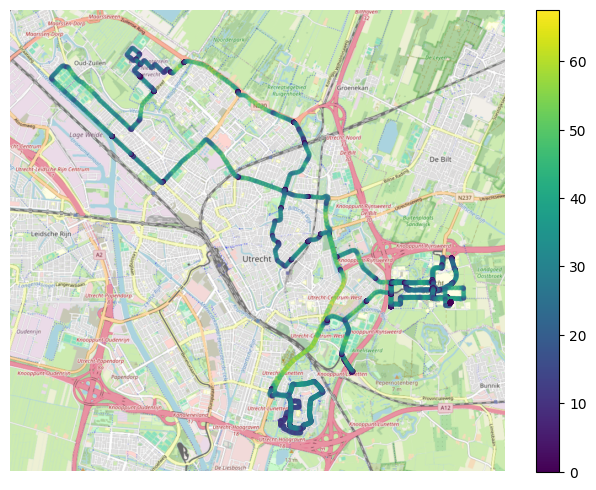

In [8]:
ax = gplt.webmap(gdf, projection=gcrs.WebMercator())
gplt.pointplot(gdf[:], hue='speed', marker='.', alpha=0.2, ax=ax, legend=True)

LEGEND <30: yellow, <20: orange, <10: red


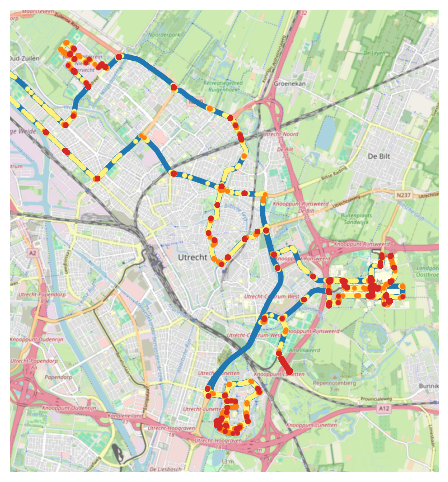

In [11]:
ax = gplt.webmap(gdf, projection=gcrs.WebMercator())
gplt.pointplot(gdf[:], marker='.', color='C0', ax=ax)
gplt.pointplot(gdf[gdf['speed'] < 30], marker='.', color='#fff27a', ax=ax)
gplt.pointplot(gdf[gdf['speed'] < 20], marker='.', color='C1', ax=ax)
gplt.pointplot(gdf[gdf['speed'] < 10], marker='.', color='C3', ax=ax)
print('LEGEND <30: yellow, <20: orange, <10: red')

### Reading in and cleaning normalizing sound data

In [71]:
soundfiles = [#'100300-recording1.wav', redacted due to inaccurate volume levels
              ('101445-recording2.wav', 113), 
              ('103545-recording3.wav', 113), 
              ('111100-recording4.wav', 145), 
              ('121648-recording5.wav', 145),
            #   ('achterafDbTest.wav', 145)
              ]
levelfile = '74DbA-tone.wav'

def signal_to_res(signal_frame, sr):
    weighted_signal = waveform_analysis.A_weight(signal_frame, sr)
    rms_value = np.sqrt(np.mean(np.abs(weighted_signal)**2))
    result = 20 * np.log10(rms_value)
    
    return result

def db_time_array(signal, sr, frame_duration=1, overlap=None):
    """
    args: 
    frame_size: in seconds
    """
    frame_size = int(frame_duration*sr)
    s_frame, e_frame = 0, frame_size+1
    result = []
    while e_frame < len(signal):
        result.append(signal_to_res(signal[s_frame:e_frame], sr))
        s_frame, e_frame = e_frame, e_frame+frame_size
    result.append(signal_to_res(signal[s_frame:], sr))
    return result

def file_to_db_list(filename, db_increment = 150):
    # 150 based on 74db tone file test
    # read in audio data
    data_folder = '..\\data\\may-collection-raw'
    file_path = os.path.join(data_folder, filename)
    signal, sr = sf.read(file_path)
    # convert to DbA values
    db_array = db_time_array(signal, sr, 1)
    db_array = [x + db_increment for x in db_array]
    return db_array

(10419,)
2024-05-08 8:14:45 511
2024-05-08 8:35:45 1771
2024-05-08 9:11:00 3886
2024-05-08 10:16:48 7834


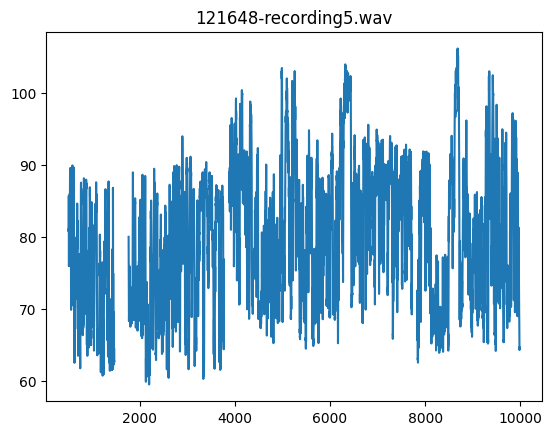

In [76]:
full_db_array = np.full(gdf.shape[0], np.NaN)
print(full_db_array.shape)
for file, adj in soundfiles:
    dba = file_to_db_list(file, adj)
    timestamp = f"2024-05-08 {int(file[:2])-2}:{file[2:4]}:{file[4:6]}"
    index = gdf[gdf['DateTime'] == timestamp].index.values[0]
    print(timestamp, index)

    full_db_array[index:index+len(dba)] = dba
    # print(timestamp)
    # print(file, dba[min(900, len(dba)-1)])
    # plt.plot(dba)
    # plt.title(file)
    # plt.show()

gdf['DbA'] = full_db_array

plt.plot(full_db_array)
plt.title(file)
plt.show()


c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\geoplot\geoplot.py:56: UserWarning: The data being passed to "hue" includes null values. You probably want to remove these before plotting this data with geoplot.
  warnings.warn(


<GeoAxes: >

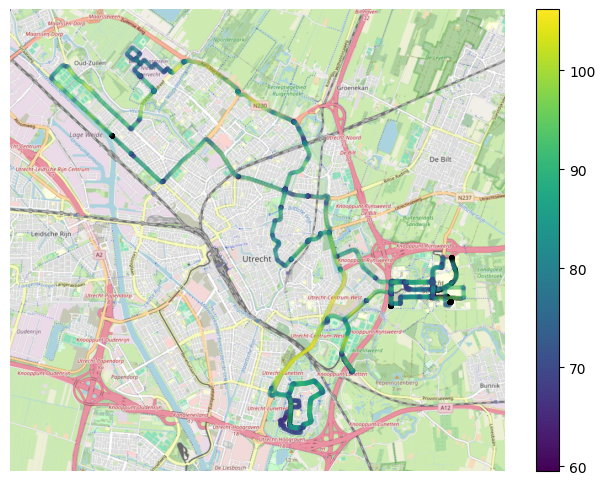

In [79]:
ax = gplt.webmap(gdf, projection=gcrs.WebMercator())
gplt.pointplot(gdf[:], hue='DbA', marker='.', alpha=0.1, ax=ax, legend=True)